# The Classification of Heart Defects from the Results of a Thalium Scintigraphy Test.

## Introduction

Thallium scintigraphy tests are a type of cardiography test used primarily within patients with artery diseases, and atypical chest pains, but can be used for a variety of heart diseases, as a form of non-invasive myocardial imaging that can tell if a patient's defect by how much blood can flow through vesicles (Arrighi, 2019). The results of this test are classified into three types: no defect, a fixed defect in which only scar tissue exists, and a reversible defect in which both scar and viable heart tissues exist (Mckillop, 1980). These tests are typically done in a clinical setting while quantifying a number of other variables such as maximum heart rate, blood pressure and age of the person taking the test, and are accompanied by other tests such as tests which quantify exercise-induced ST depression. The goal of this project is to answer how are the results of a Thallium scintigraphy test determining heart defect severity, and therefore how is heart defect severity, affected by age, resting blood pressure, maximum heart rate achieved in-test, and ST depression. We think that the four predictor variables will all impact the likelihood of the THAL test having a specific result. For AGE for example, previous research has shown that heart failure is very common in elderly due to the fact that the structure and function of the heart is affected by a variety of factors, including natural aging, chronic disease and medication, so we would predict that the results will show an increase in fixed defects and reversible defects in older people (Benjamin, 2019). ST depression (OLDPEAK) can also play a role in signifying heart disease as it is the difference between ST-segment depression observed during exercise compared to rest, higher depressions increase chances for more severe defects (Lazzarni, 2013). Abnormally high heart rate (THALACH), which is quantified in the THAL tests can also be considered as a sign of heart diseases (Bassan, 2005), this is also seen in systolic blood pressure (TRESTBPS) which when high can actually lead to a higher chance of getting a heart defect (Vasan, 2001). From the above information we can see that each of these variables can be used as predictors and thus can be helpful in  real-life settings. Quantifying which variables are significant predictors can help healthcare workers or patients themselves determine when to look for a heart defect, for example increasing the frequency of tests once a patient reaches the age that our data shows an increase of heart defects at. 

## Methods and Results

We will analyze the “Cleveland Heart Disease” dataset to determine how certain variables affect what kind of heart defect someone has. This dataset originally had 76 variables, but we will be using the processed dataset which has only 14, which we further limited to **thal**, **thalach**, **age**, **oldpeak**, and **trestbps** which we believe will be important signifiers of the results. We will be creating a classifier that will help us to classify the presence or absence of a heart defect and its type, reversible or irreversible. 

### Preprocessing and Exploratory Data Analysis


#### Loading in Libraries and Data Set

In this first step, we import different libraries that we need to perform our data analysis.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
install.packages("kknn")
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.1.3”
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ pars

In the second step, we load the `processed.cleveland.data` dataset from the internet. This data is not yet suitable for our data analysis, so some changes to the data must be made before we start.

#### Table 1: Processed Cleveland Dataset

In [2]:
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
        col_names = FALSE)
cleveland_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


#### Tidying the Data Set

In the third step, we clean and tidy the data to make it suitable for our data analysis.

When looking at **Table 1**, the data frame does not contain any column names, and some columns should be under the datatype `<fct>` but are labelled as `<dbl>` or `<chr>`. These need to be changed to make the data tidy. It can also be seen that each column only contains numbers, with missing data being represented by a question mark.

To tidy our data, we first added the appropriate column names listed on the website where the data set was obtained by using `colnames` on the imported data set. After, we selected the columns needed for our analysis: **age**, **trestbps**, **chol**, **oldpeak**, and **thal**. The columns that contain question marks to represent missing data are not in a very useful form, `mutate` and `across` were used to change the question marks into NA values that can be used.

The **thal** column must be modified so that the actual class names are shown instead of numbers. The website where the data set was obtained indicates that normal is when **thal** = 3.0, fixed defect is when **thal** = 6.0, and reversible defect is when **thal** = 7.0. Once this step was completed, `mutate` was used to change the data type from `<chr>` to `<fct>`.

#### Table 2: Tidy Processed Cleveland Dataset

In [3]:
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

tidy_cleveland_data <- cleveland_data |>
select("age", "trestbps", "chol", "thalach", "oldpeak", "thal") |>
mutate(across(age:thal, ~na_if(., "?"))) #This line of code was referenced from Wickham et al. (n.d.)
tidy_cleveland_data$thal[tidy_cleveland_data$thal == "3.0"] <- "normal" #This line of code was referenced from Naveen (2022)
tidy_cleveland_data$thal[tidy_cleveland_data$thal == "6.0"] <- "fixed_defect" #This line of code was referenced from Naveen (2022)
tidy_cleveland_data$thal[tidy_cleveland_data$thal == "7.0"] <- "reversible_defect" #This line of code was referenced from Naveen (2022)
tidy_cleveland_data <- mutate(tidy_cleveland_data, thal = as.factor(thal))
tidy_cleveland_data

age,trestbps,chol,thalach,oldpeak,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,fixed_defect
67,160,286,108,1.5,normal
67,120,229,129,2.6,reversible_defect
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,reversible_defect
57,130,236,174,0.0,normal
38,138,175,173,0.0,normal


#### Splitting the Data Set Into Training and Testing Sets

Once the data is tidy, it can be split into training and testing sets. We set a random seed to ensure that the random split is reproducible and used `initial_split` to split the data frame. The data was divided, with 75% for the training set and 25% for the testing set, with `strata` being set to **thal**. The use of `initial_split` ensures there is no bias in dividing the data set and maintains the proportions of each class. Splitting the data allows for the model to be trained and then tested afterward. 

The split provided 227 rows in the training set and 76 rows in the testing set (seen by the tibble displaying the number of rows in **Table 3** and **Table 4** below). Having this amount of data in each set means that there will be enough data to train a classifier and evaluate its performance. From this point forward, only the training set will be used until the data is tested.

#### Table 3: Training Cleveland Dataset

In [4]:
set.seed(234) 
cleveland_split <- initial_split(tidy_cleveland_data, prop = 0.75, strata = thal)  
cleveland_train <- training(cleveland_split)   
cleveland_train

age,trestbps,chol,thalach,oldpeak,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,fixed_defect
37,130,250,187,3.5,normal
41,130,204,172,1.4,normal
⋮,⋮,⋮,⋮,⋮,⋮
63,140,187,144,4.0,reversible_defect
68,144,193,141,3.4,reversible_defect
57,130,131,115,1.2,reversible_defect


#### Table 4: Testing Cleveland Dataset

In [5]:
set.seed(234) 
cleveland_test <- testing(cleveland_split)
cleveland_test

age,trestbps,chol,thalach,oldpeak,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
67,160,286,108,1.5,normal
67,120,229,129,2.6,reversible_defect
62,140,268,160,3.6,normal
⋮,⋮,⋮,⋮,⋮,⋮
57,140,241,123,0.2,reversible_defect
45,110,264,132,1.2,reversible_defect
57,130,236,174,0.0,normal


#### Summarizing the Data

To complete the exploratory data analysis, we created 4 different tables that display what data can be found in our training set. 

The wide range of mean values for each predictor seen in **Table 5** (made using `summarize` and `across`) indicates that our classification model most likely needs to scale and centre the predictors as some means are much larger than others, which will impact how k-nearest neighbours classify each point. **Table 6** (made using `group_by` and `summarize`) shows that there is a higher proportion of individuals classified as normal or having a reversible defect. This indicates the majority of the classes predicted by the classifier would be normal and reversible defects. **Table 7** (finds observations with NA values) and **Table 8** (uses `map_df` to sum NA values in each column) display that there are not many NA values, so they won't affect the classification by much.

#### Table 5: Means of the Predictor Variables 

In [6]:
cleveland_table <- cleveland_train |>
summarize(across(age:oldpeak, mean))
cleveland_table

age,trestbps,chol,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53.95595,131.5903,244.2952,150.5507,1.040088


#### Table 6: Number of Observations in Each Class

In [7]:
cleveland_table_2 <- group_by(cleveland_train, thal) |>
summarize(count = n())
cleveland_table_2

thal,count
<fct>,<int>
fixed_defect,12
normal,126
reversible_defect,88
NA,1


#### Table 7: Rows That Have Missing Data

In [8]:
cleveland_table_3 <- cleveland_train[!complete.cases(cleveland_train), ] #This line of code was referenced from Gili (2022)
cleveland_table_3

age,trestbps,chol,thalach,oldpeak,thal
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
53,128,216,115,0,NA


#### Table 8: Number of Rows That Have Missing Data per Column

In [9]:
cleveland_table_4 <- cleveland_train |>
    map_df(~ sum(is.na(.))) #This line of code was referenced from Kiniry (2019).
cleveland_table_4

age,trestbps,chol,thalach,oldpeak,thal
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,1


#### Visualizing the Data

The visualizations below contain histograms that show how many of each class are found at different values of the predictors. The visualizations show that the trends of some predictors in the data set such as **chol** and **thalach** don’t exactly follow our preliminary research.

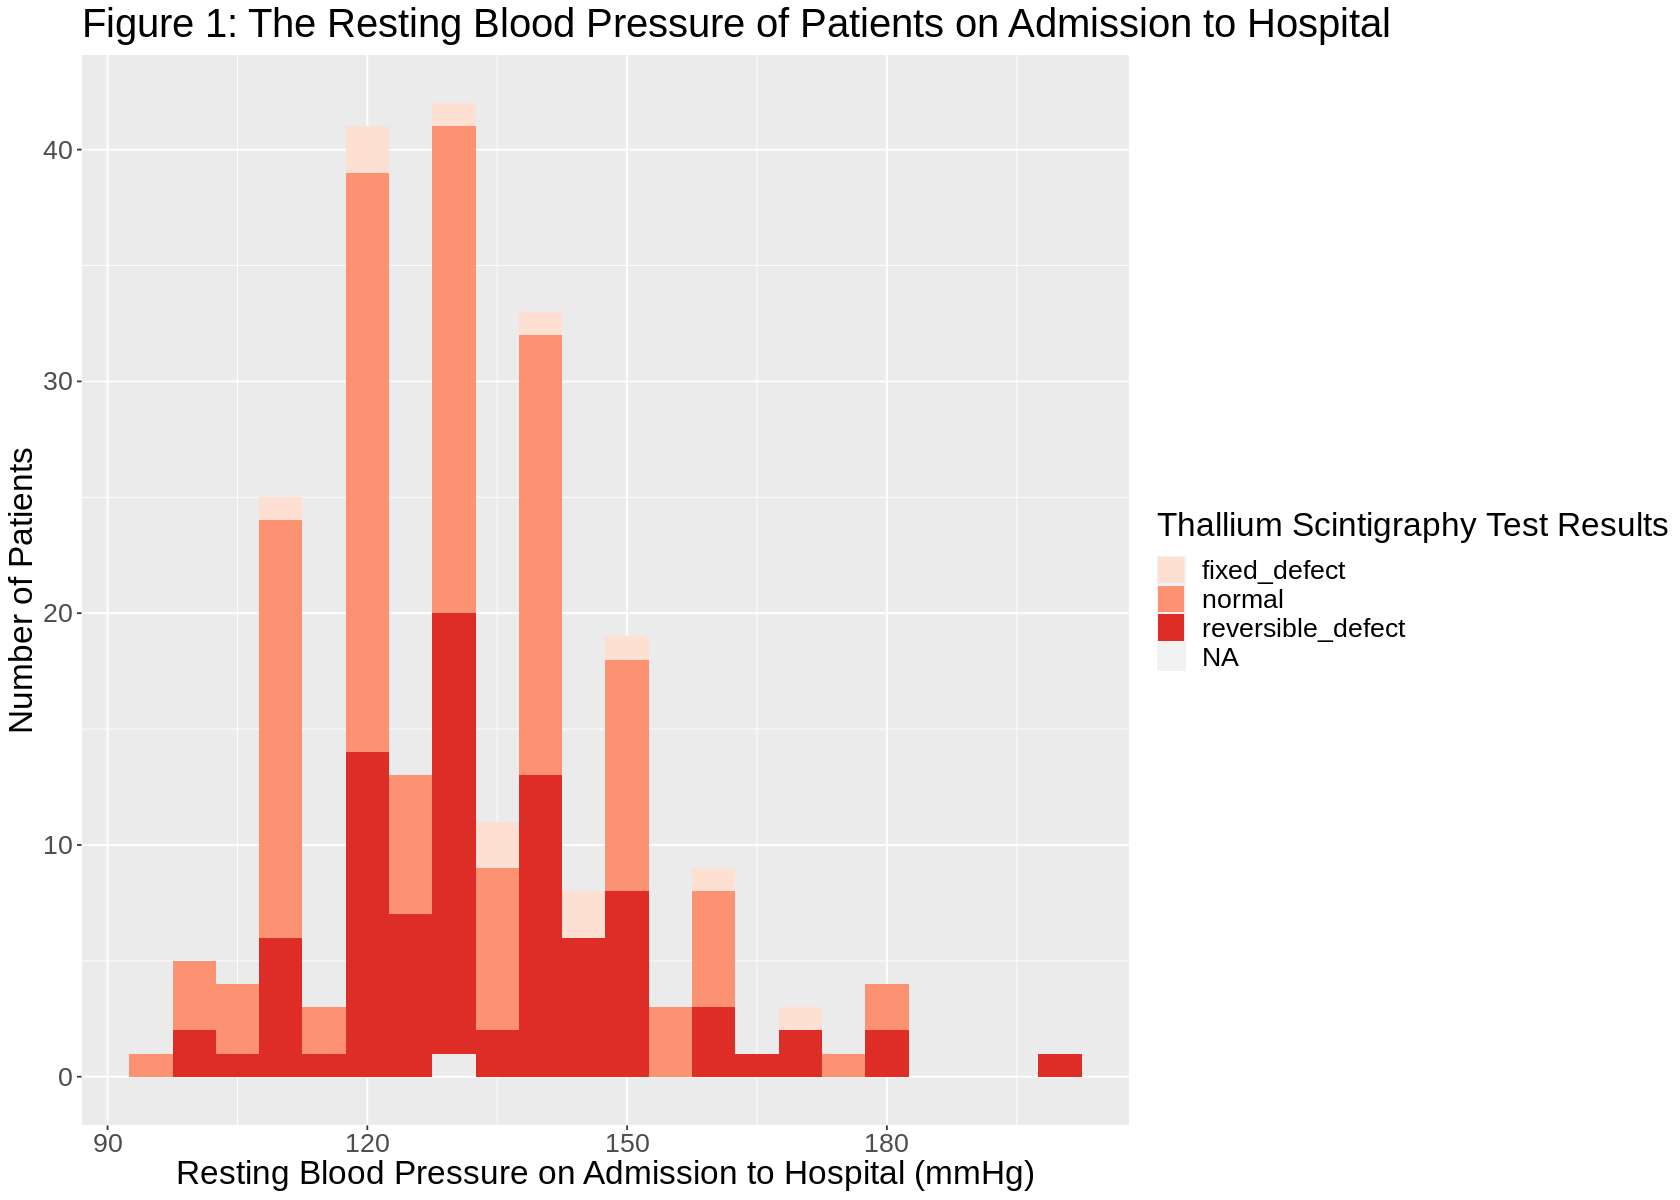

In [10]:
options(repr.plot.width = 14, repr.plot.height = 10)
cleveland_plot_1 <- cleveland_train |>
    ggplot(aes(x = trestbps, fill = thal)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Resting Blood Pressure on Admission to Hospital (mmHg)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 1: The Resting Blood Pressure of Patients on Admission to Hospital") +
    scale_fill_brewer(palette = "Reds")+
    theme(text = element_text(size = 20))
cleveland_plot_1

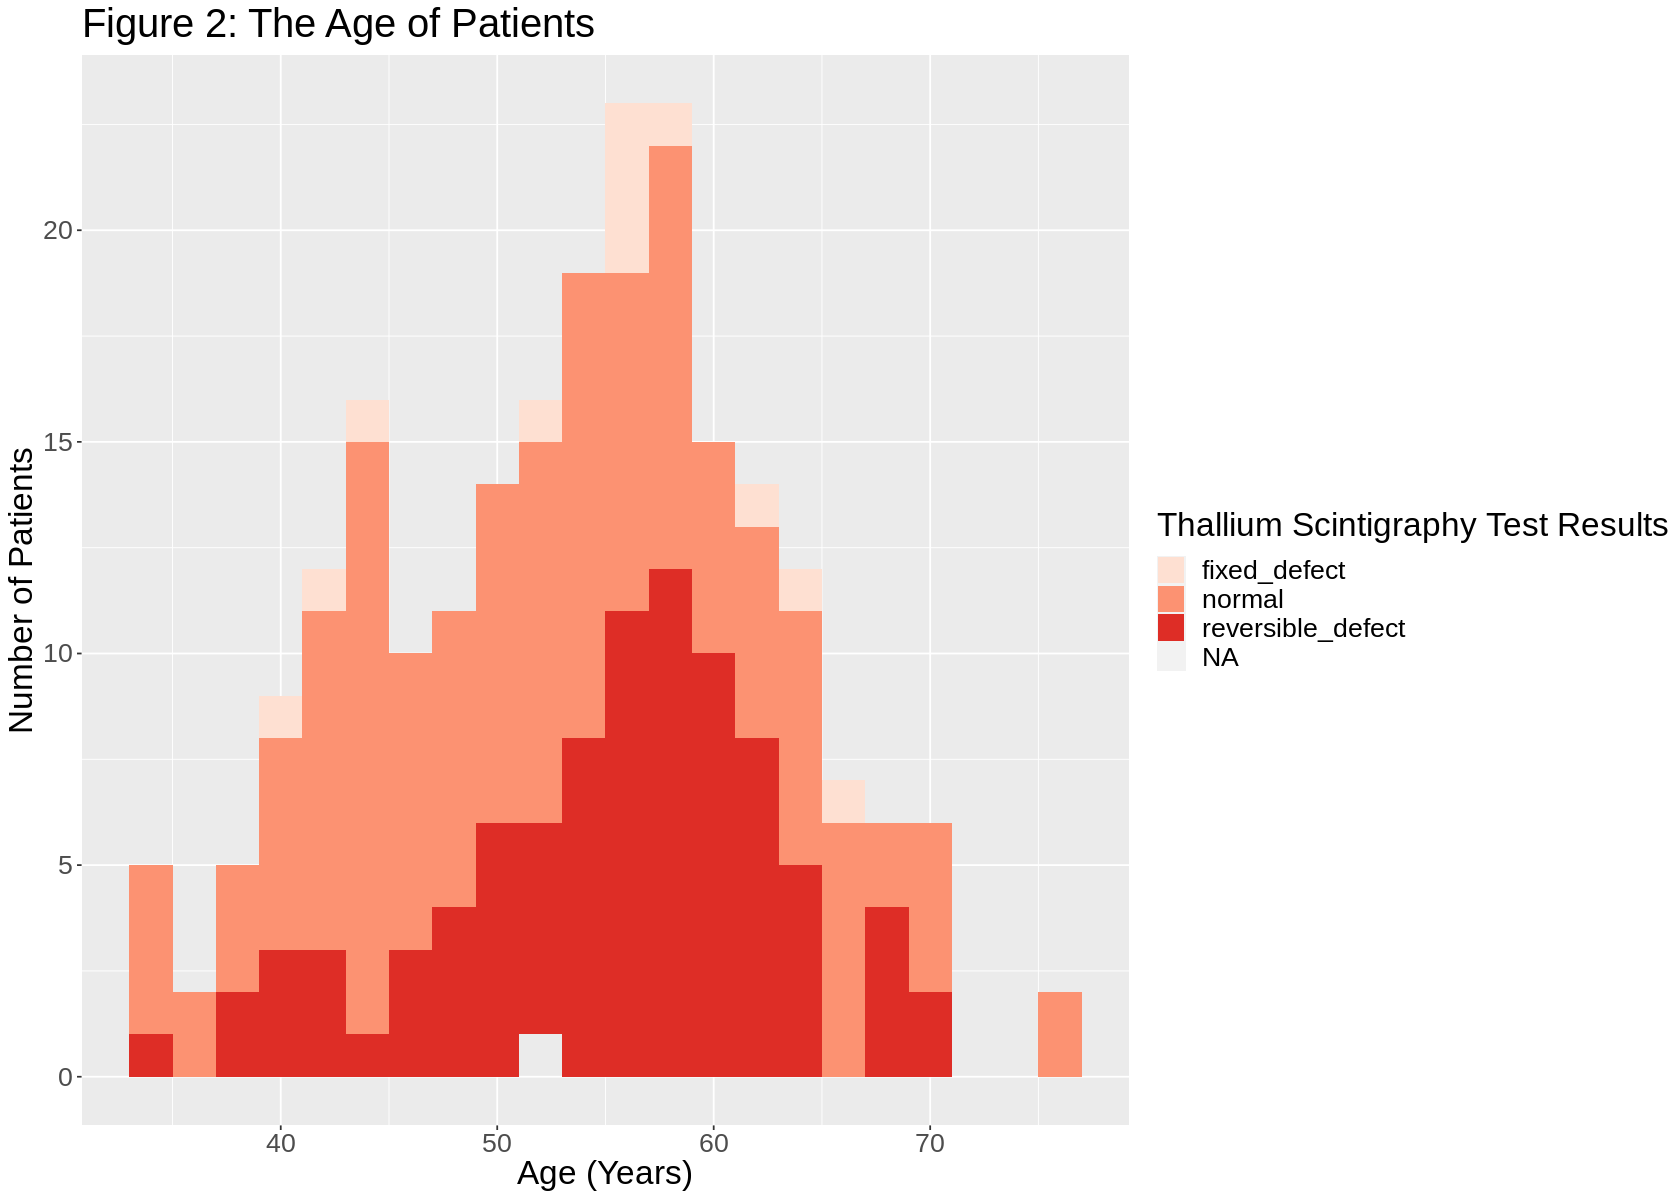

In [11]:
cleveland_plot_2 <- cleveland_train |>
    ggplot(aes(x = age, fill = thal)) +
    geom_histogram(binwidth = 2) +
    labs(x = "Age (Years)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 2: The Age of Patients") +
    scale_fill_brewer(palette = "Reds") +
    theme(text = element_text(size = 20))
cleveland_plot_2

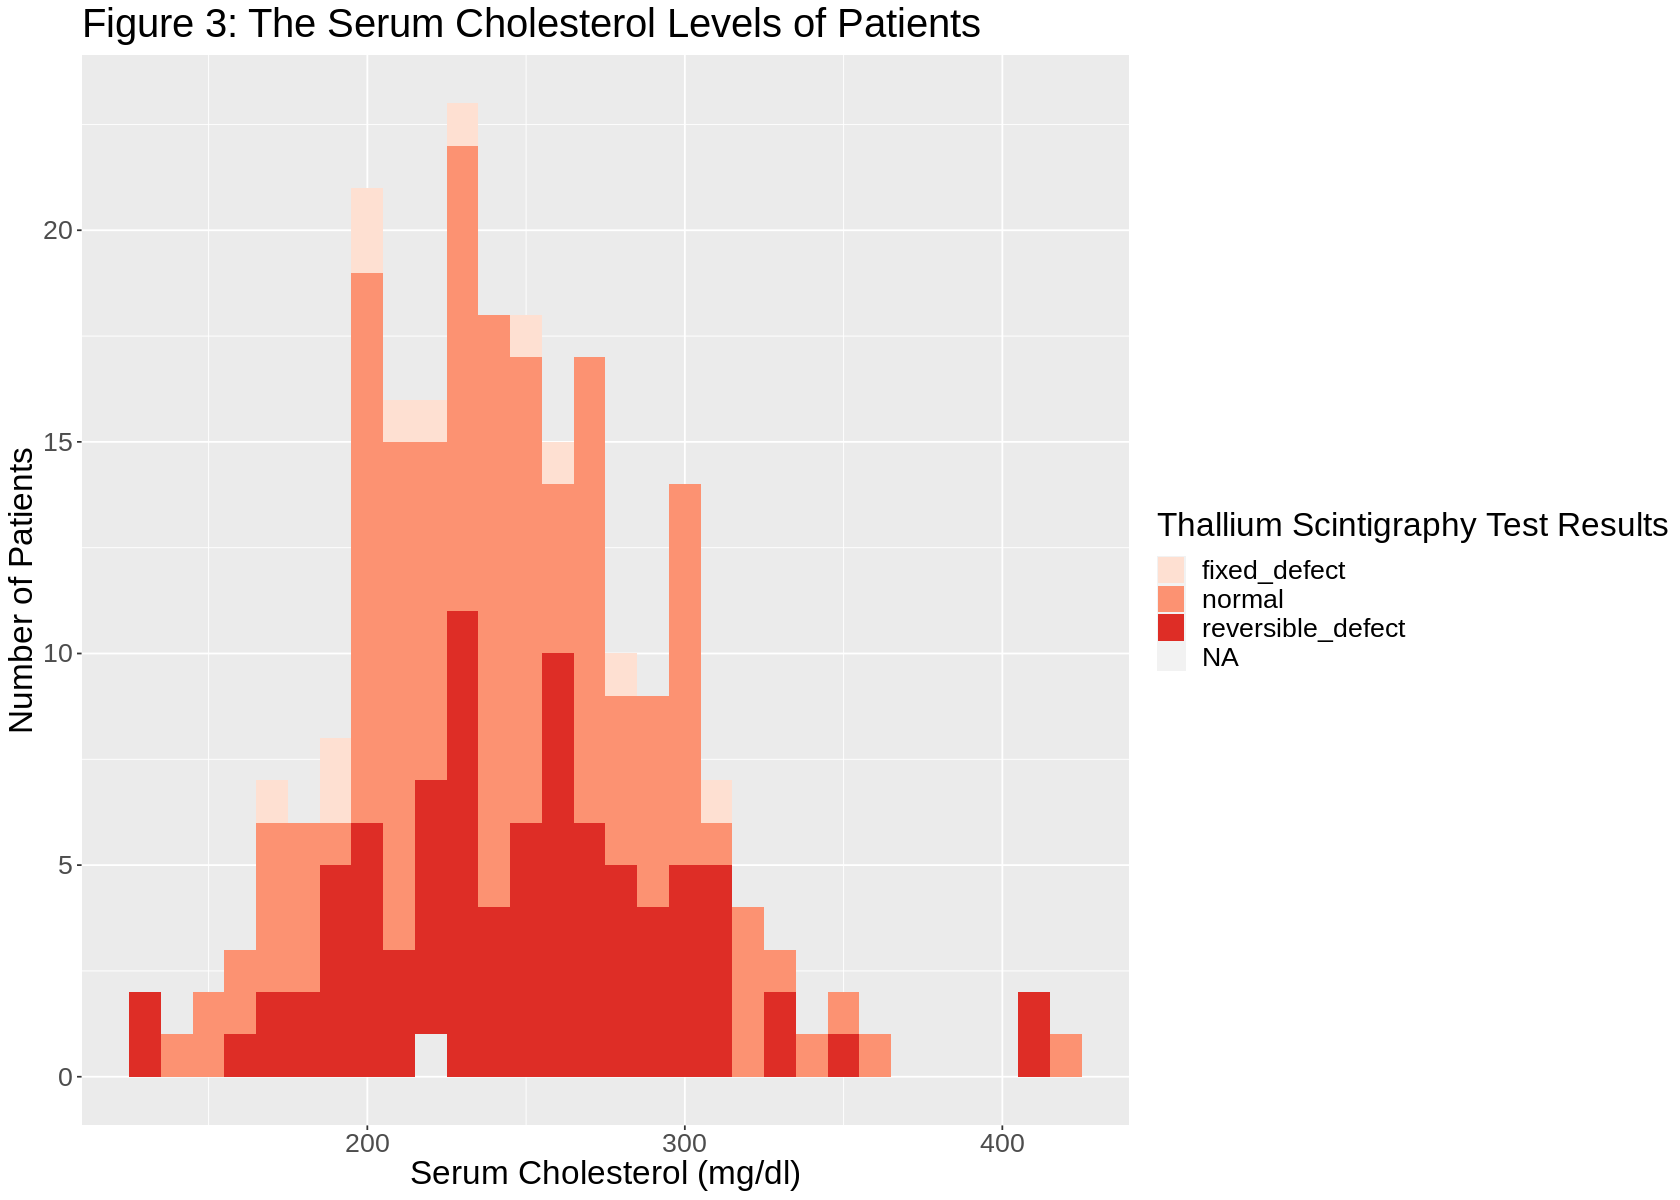

In [12]:
cleveland_plot_3 <- cleveland_train |>
    ggplot(aes(x = chol, fill = thal)) +
    geom_histogram(binwidth = 10) +
    labs(x = "Serum Cholesterol (mg/dl)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 3: The Serum Cholesterol Levels of Patients") +
    scale_fill_brewer(palette = "Reds") +
    theme(text = element_text(size = 20))
cleveland_plot_3

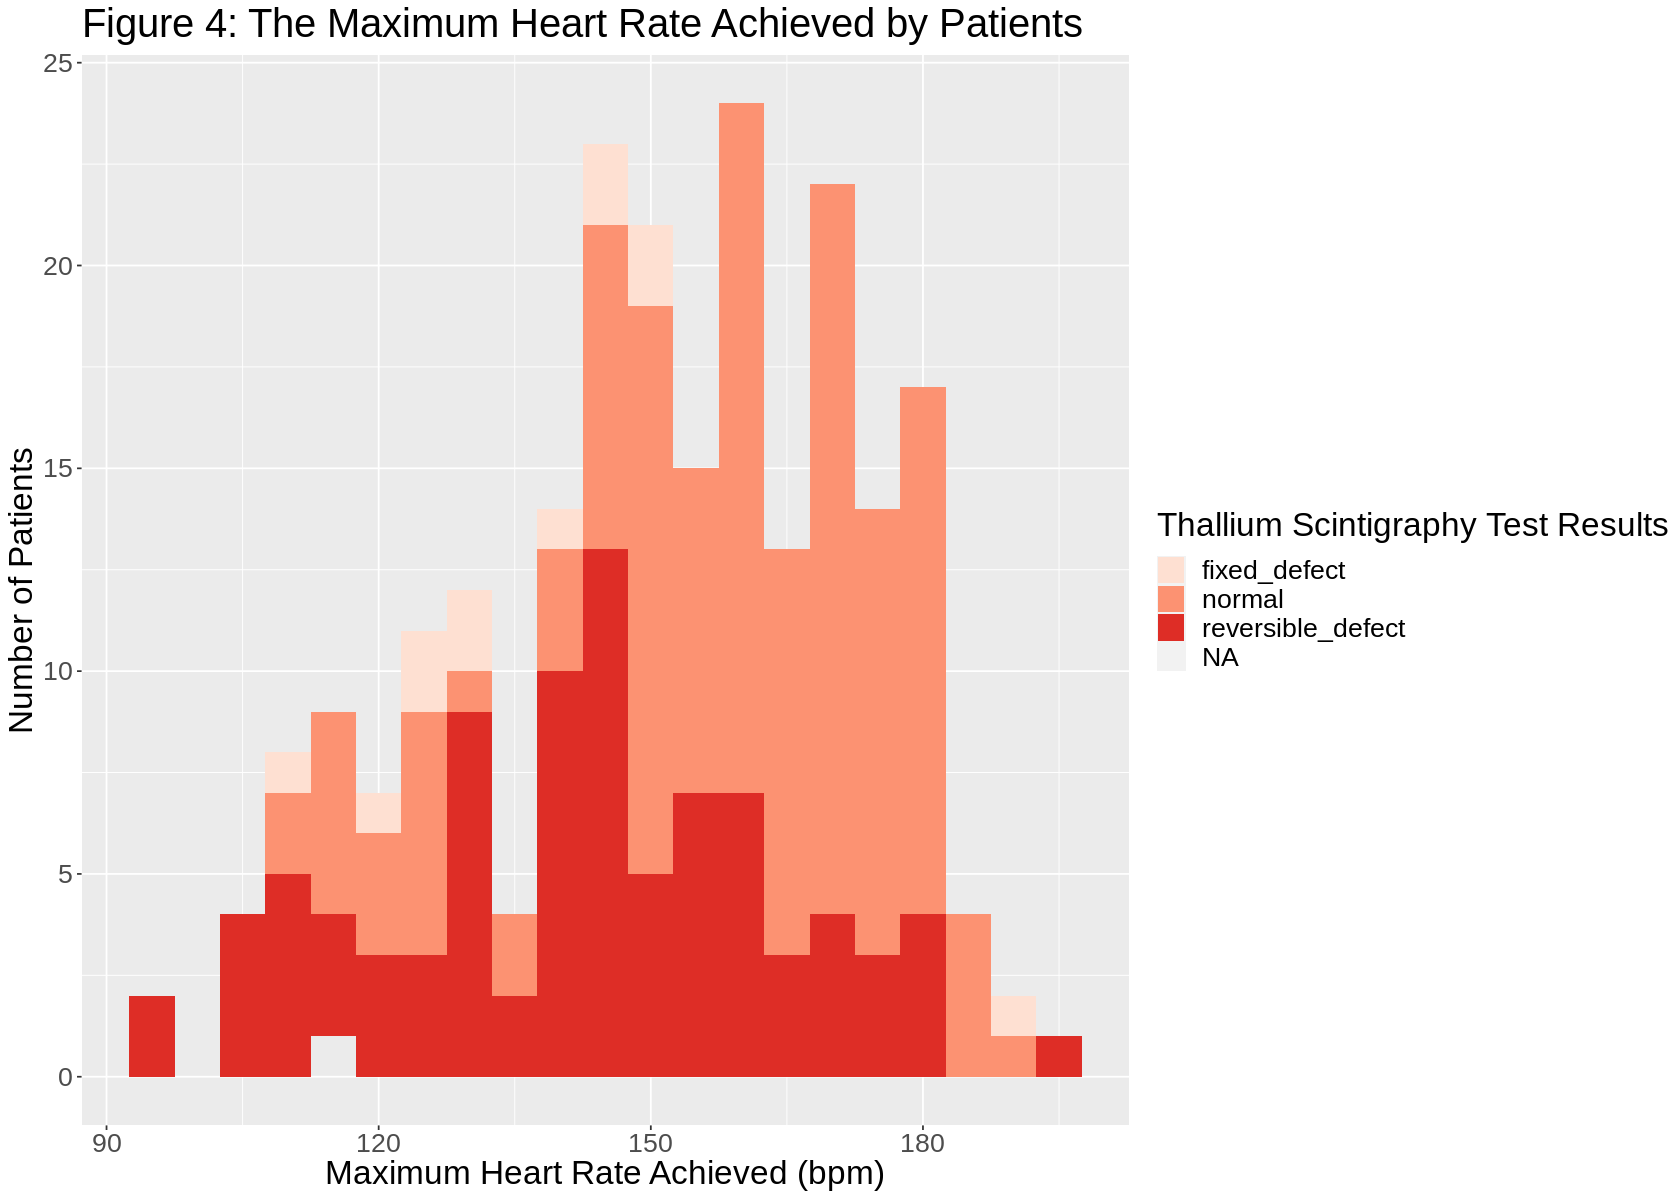

In [13]:
cleveland_plot_4 <- cleveland_train |>
    ggplot(aes(x = thalach, fill = thal)) +
    geom_histogram(binwidth = 5) +
    labs(x = "Maximum Heart Rate Achieved (bpm)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 4: The Maximum Heart Rate Achieved by Patients") +
    scale_fill_brewer(palette = "Reds") +
    theme(text = element_text(size = 20))
cleveland_plot_4

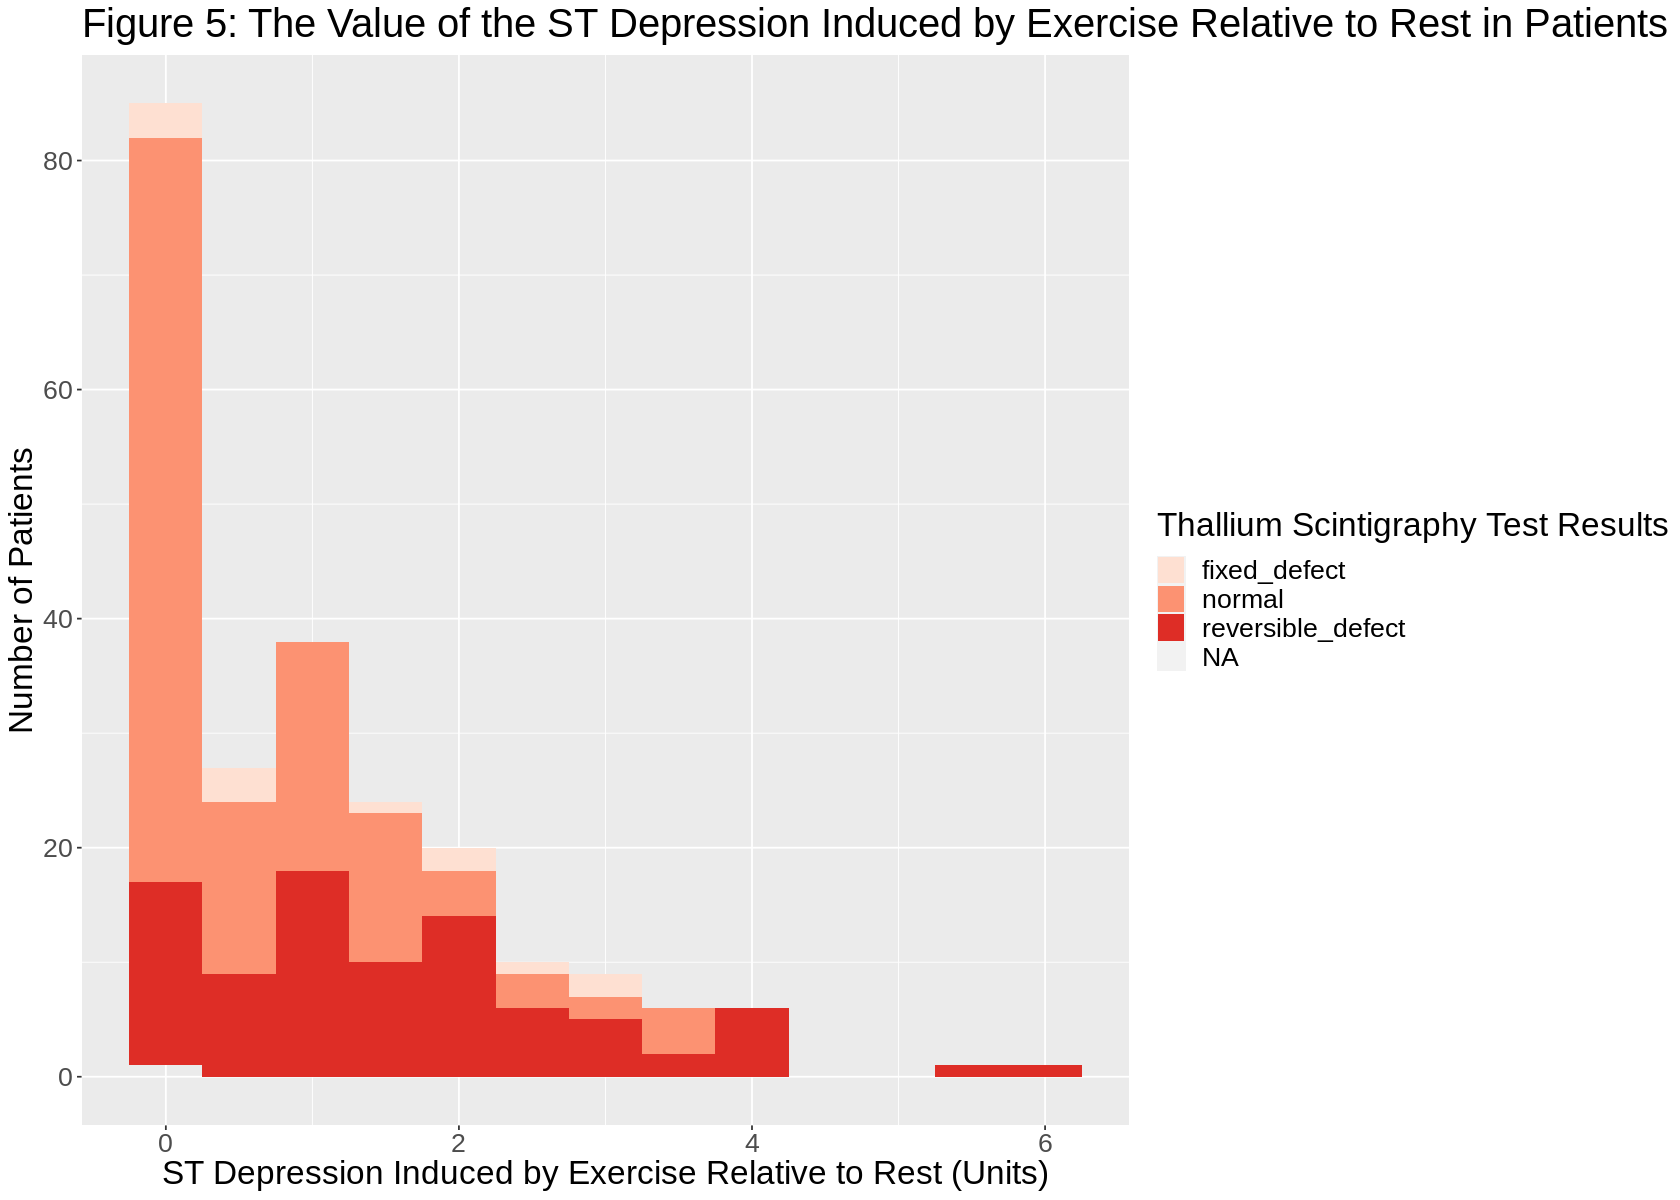

In [14]:
cleveland_plot_5 <- cleveland_train |>
    ggplot(aes(x = oldpeak, fill = thal)) +
    geom_histogram(binwidth = 0.5) +
    labs(x = "ST Depression Induced by Exercise Relative to Rest (Units)", y = "Number of Patients",  fill = "Thallium Scintigraphy Test Results") +
    ggtitle("Figure 5: The Value of the ST Depression Induced by Exercise Relative to Rest in Patients") +
    scale_fill_brewer(palette = "Reds") +
    theme(text = element_text(size = 20))
cleveland_plot_5

### Choosing a K Value

To create the classification model, a seed was set to ensure that the cross-validation was reproducible. A recipe was created using `cleveland_training` to predict the class of **thal**, with **age**, **trestbps**, **chol**, **oldpeak**, and **thal** as predictors. A specification was created with k-nearest neighbours and the function `tune()` to set up cross-validation. The training data is then set to split into 5 equal folds using `vfold_cv` and setting `strata`to **thal**. A tibble was made with $k$ values from 1 to 20 because there are only 76 points in the test set and having higher k values would make testing less effective. A workflow was then created by adding the recipe, mode, and using `tune_grid` with the $k$ value Tibble. A graph using `geom_line` was made to see how accuracy changes at different $k$ values. We plot a graph comparing neighbours (k) and accuracy.

Looking at the graph in **Figure 6**, the best $k$ value would be 17 as it has the highest accuracy and the accuracy of the adjacent points does not drop much. 

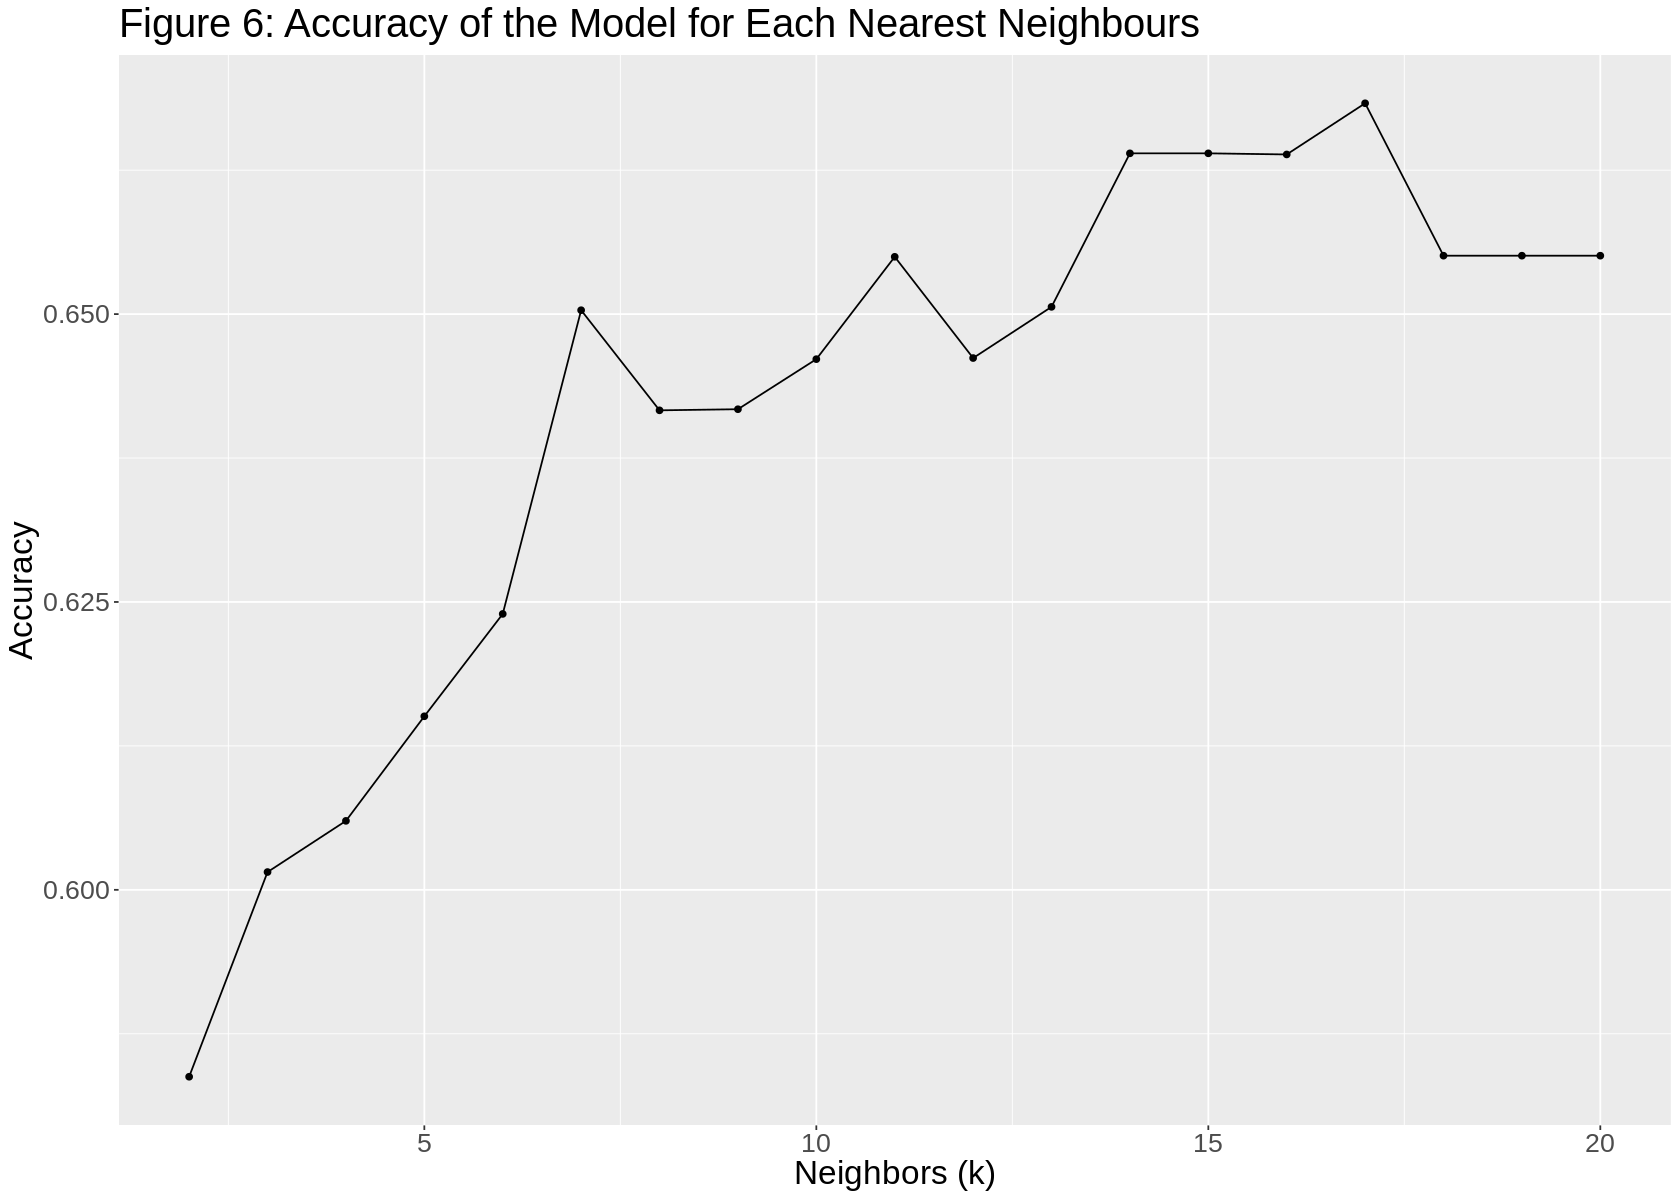

In [15]:
set.seed(69)

cleveland_recipe <- recipe(thal ~ ., data = cleveland_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
       set_engine("kknn") |>
       set_mode("classification")

cleveland_vfold <- vfold_cv(cleveland_train, v = 5, strata = thal)

k_value <- tibble(neighbors = seq(from = 2, to = 20, by = 1))

cleveland_results <- workflow() |>
       add_recipe(cleveland_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = cleveland_vfold, grid = k_value) |>
       collect_metrics()

cross_val_plot <- cleveland_results |>
filter(.metric == "accuracy") |>
ggplot(aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors (k)", y = "Accuracy", title = "Figure 6: Accuracy of the Model for Each Nearest Neighbours") +
  theme(text = element_text(size = 20))
cross_val_plot


### Building the Classification Model

To build the model, we take the best $k$ value. We make a spec using a neighbors of 17 and then create a workflow with the new spec and fit it using the training set.

In [16]:
cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
       set_engine("kknn") |>
       set_mode("classification")

cleveland_fit <- workflow() |>
       add_recipe(cleveland_recipe) |>
       add_model(cleveland_spec) |>
       fit(data = cleveland_train)
cleveland_fit


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3628319
Best kernel: rectangular
Best k: 17

### Testing the Classification Model

To test the classification model using the test set, `predict` was used using `cleveland_fit` and `cleveland_test`. We then bind the predicted columns to the test set to see which classes were guessed correctly. The accuracy was determined using `metrics` and a confusion matrix was made using `conf_mat`.

#### Table 9: Predicted Class Compared to Test Set Class 

In [17]:
cleveland_predictions <- predict(cleveland_fit, cleveland_test) |>
       bind_cols(cleveland_test)
cleveland_predictions

.pred_class,age,trestbps,chol,thalach,oldpeak,thal
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
reversible_defect,67,160,286,108,1.5,normal
reversible_defect,67,120,229,129,2.6,reversible_defect
reversible_defect,62,140,268,160,3.6,normal
⋮,⋮,⋮,⋮,⋮,⋮,⋮
reversible_defect,57,140,241,123,0.2,reversible_defect
normal,45,110,264,132,1.2,reversible_defect
normal,57,130,236,174,0.0,normal


#### Table 10: Accuracy of Classification Model on the Test Set

In [18]:
cleveland_metrics <- cleveland_predictions |>
metrics(truth = thal, estimate = .pred_class) |>
filter(.metric == "accuracy")
cleveland_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5866667


#### Table 11: Confusion Matrix of Classification Model on the Test Set

In [19]:
cleveland_conf_mat <- cleveland_predictions |>
       conf_mat(truth = thal, estimate = .pred_class)
cleveland_conf_mat

                   Truth
Prediction          fixed_defect normal reversible_defect
  fixed_defect                 0      0                 0
  normal                       0     31                16
  reversible_defect            6      9                13

#### Visualizations of How Predictors Impact Classification 

The following plots display real classes and misclassified data while comparing two predictors. All the graphs will compare **age** to another predictor variable. The true classes are plotted using `geom_point` and the misclassified points will also be identified/plotted on the graph (over top of the true classes) using `geom_point`. The misclassified points are identified by creating a new tibble that includes all the observations where `.pred_class` did not match `thal`. These graphs will be discussed further in the discussion section.

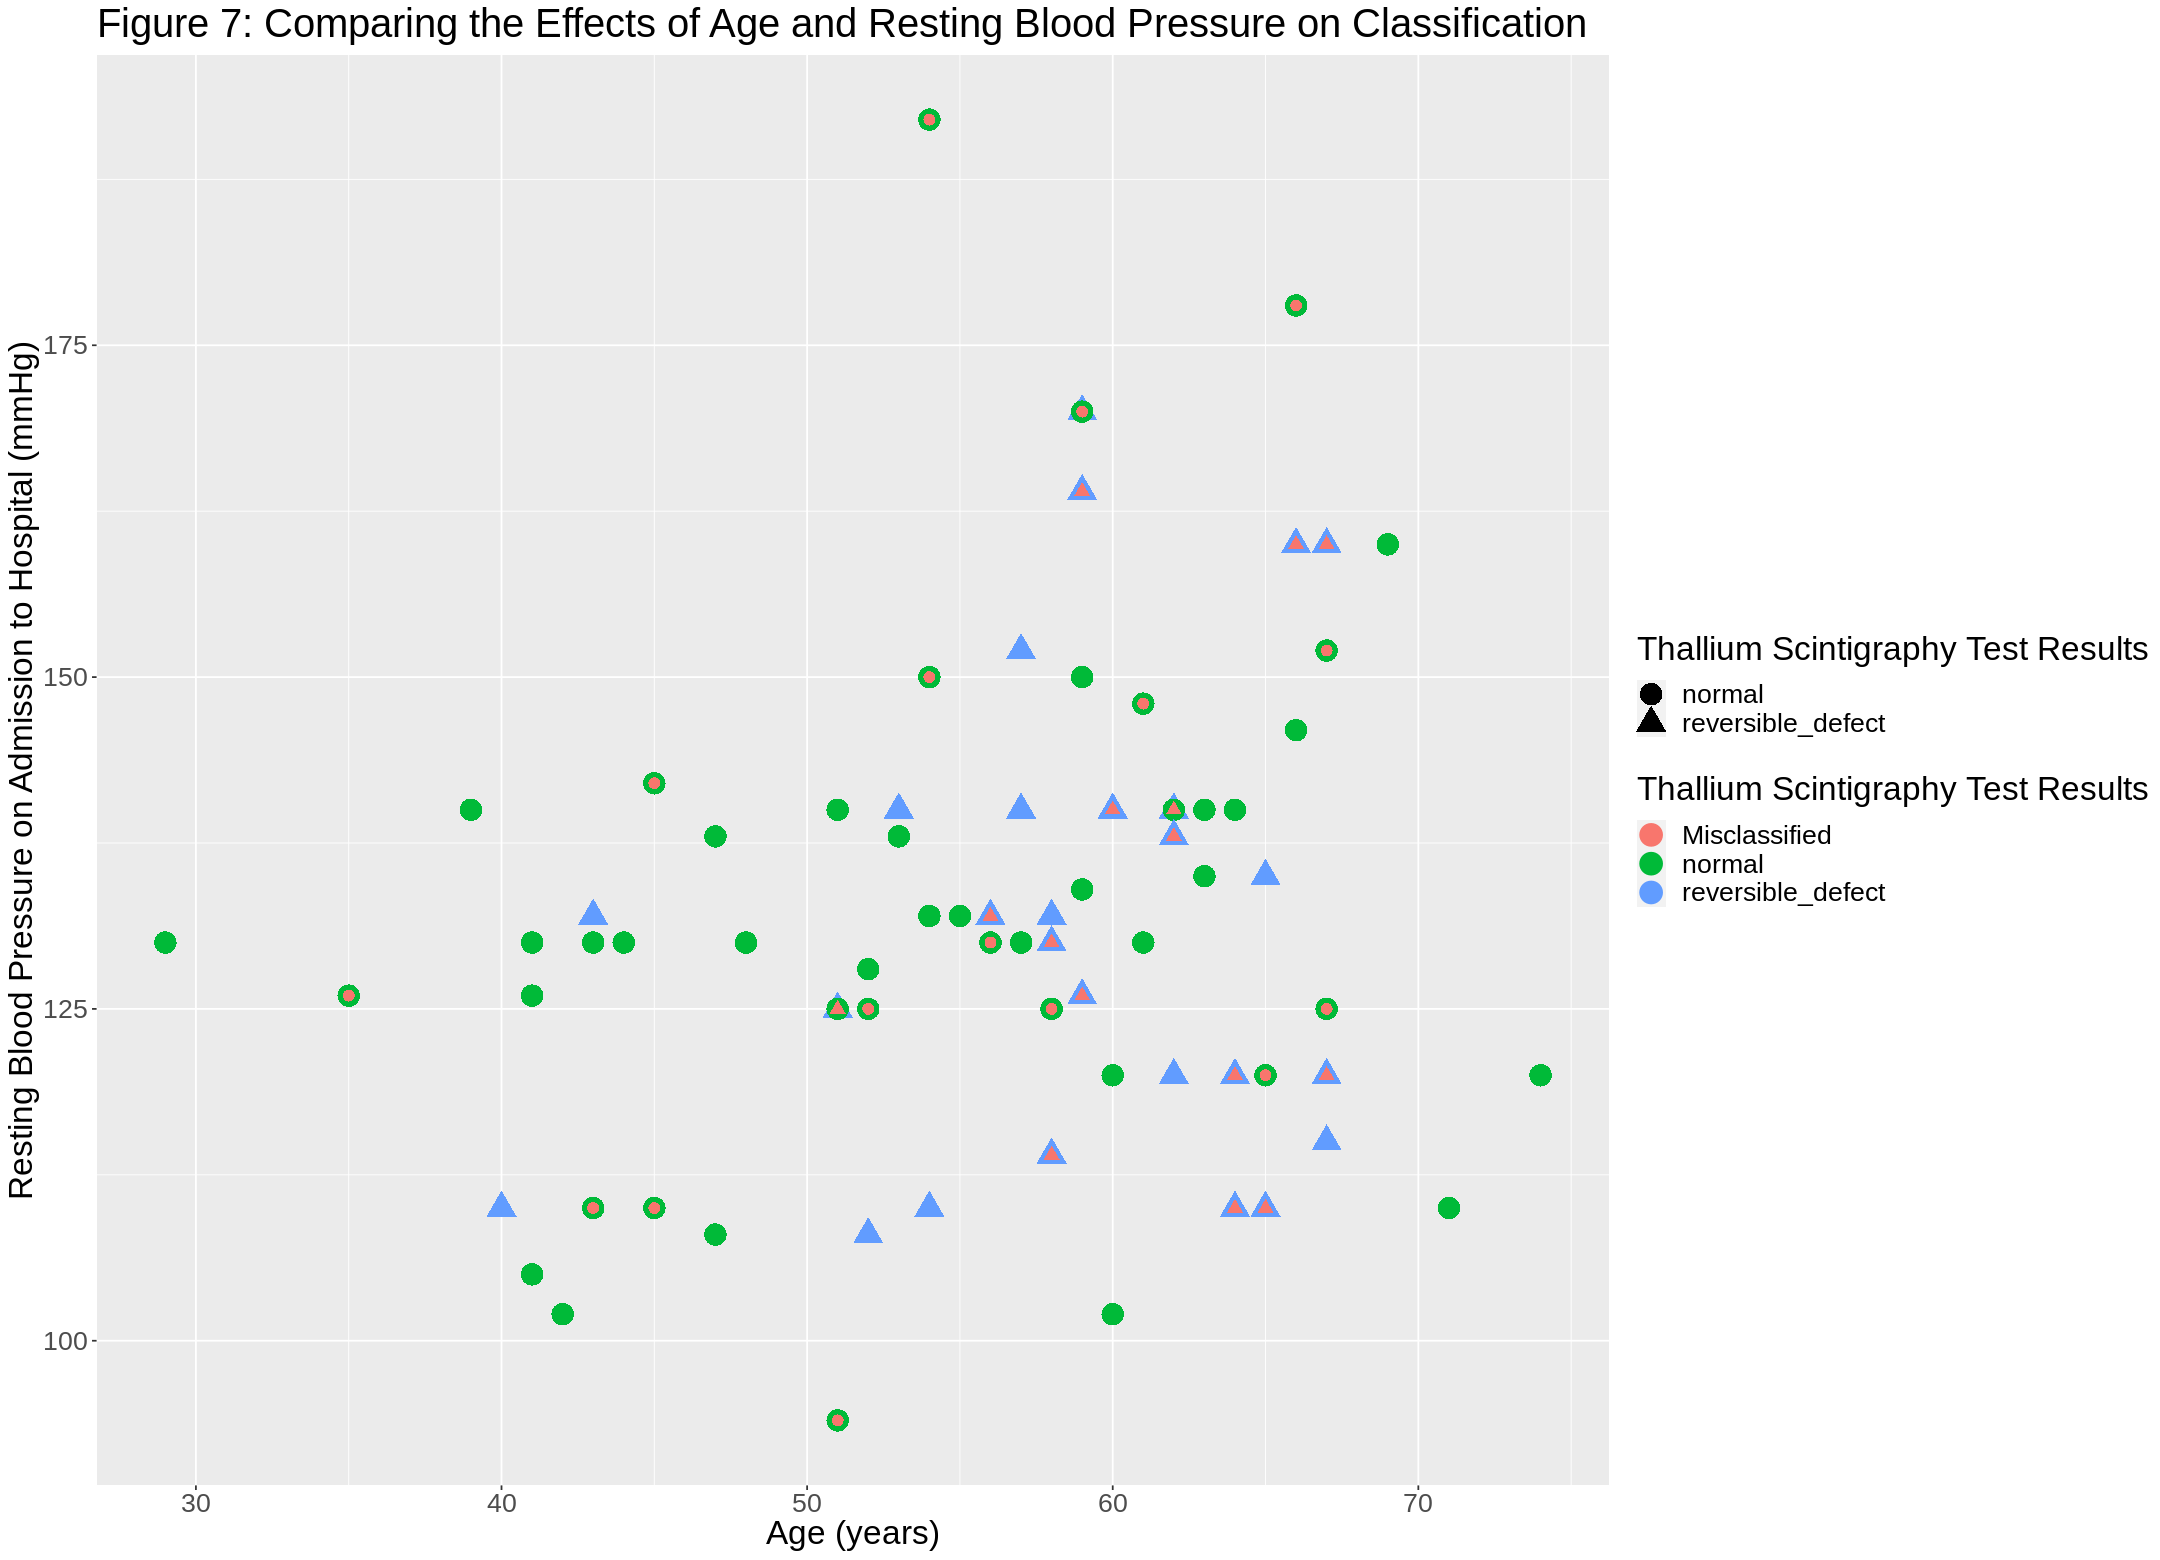

In [20]:
options(repr.plot.width = 18, repr.plot.height = 13)
cleveland_misclass <- cleveland_predictions |>
                filter(.pred_class != thal) |>
                mutate(misclassified = .pred_class) 

misclass_plot_1_pred <- ggplot(cleveland_predictions, aes(x = age, y = trestbps, color = .pred_class, shape = .pred_class)) +
                geom_point(size = 6) +
                geom_point(data = cleveland_misclass, aes(x = age, y = trestbps, color = 'Misclassified'), size = 3) +
                labs(x = "Age (years)", y = "Resting Blood Pressure on Admission to Hospital (mmHg)", 
                     title = "Figure 7: Comparing the Effects of Age and Resting Blood Pressure on Classification", 
                     color = "Thallium Scintigraphy Test Results", shape = "Thallium Scintigraphy Test Results") +
                theme(text = element_text(size = 20))

misclass_plot_1_pred

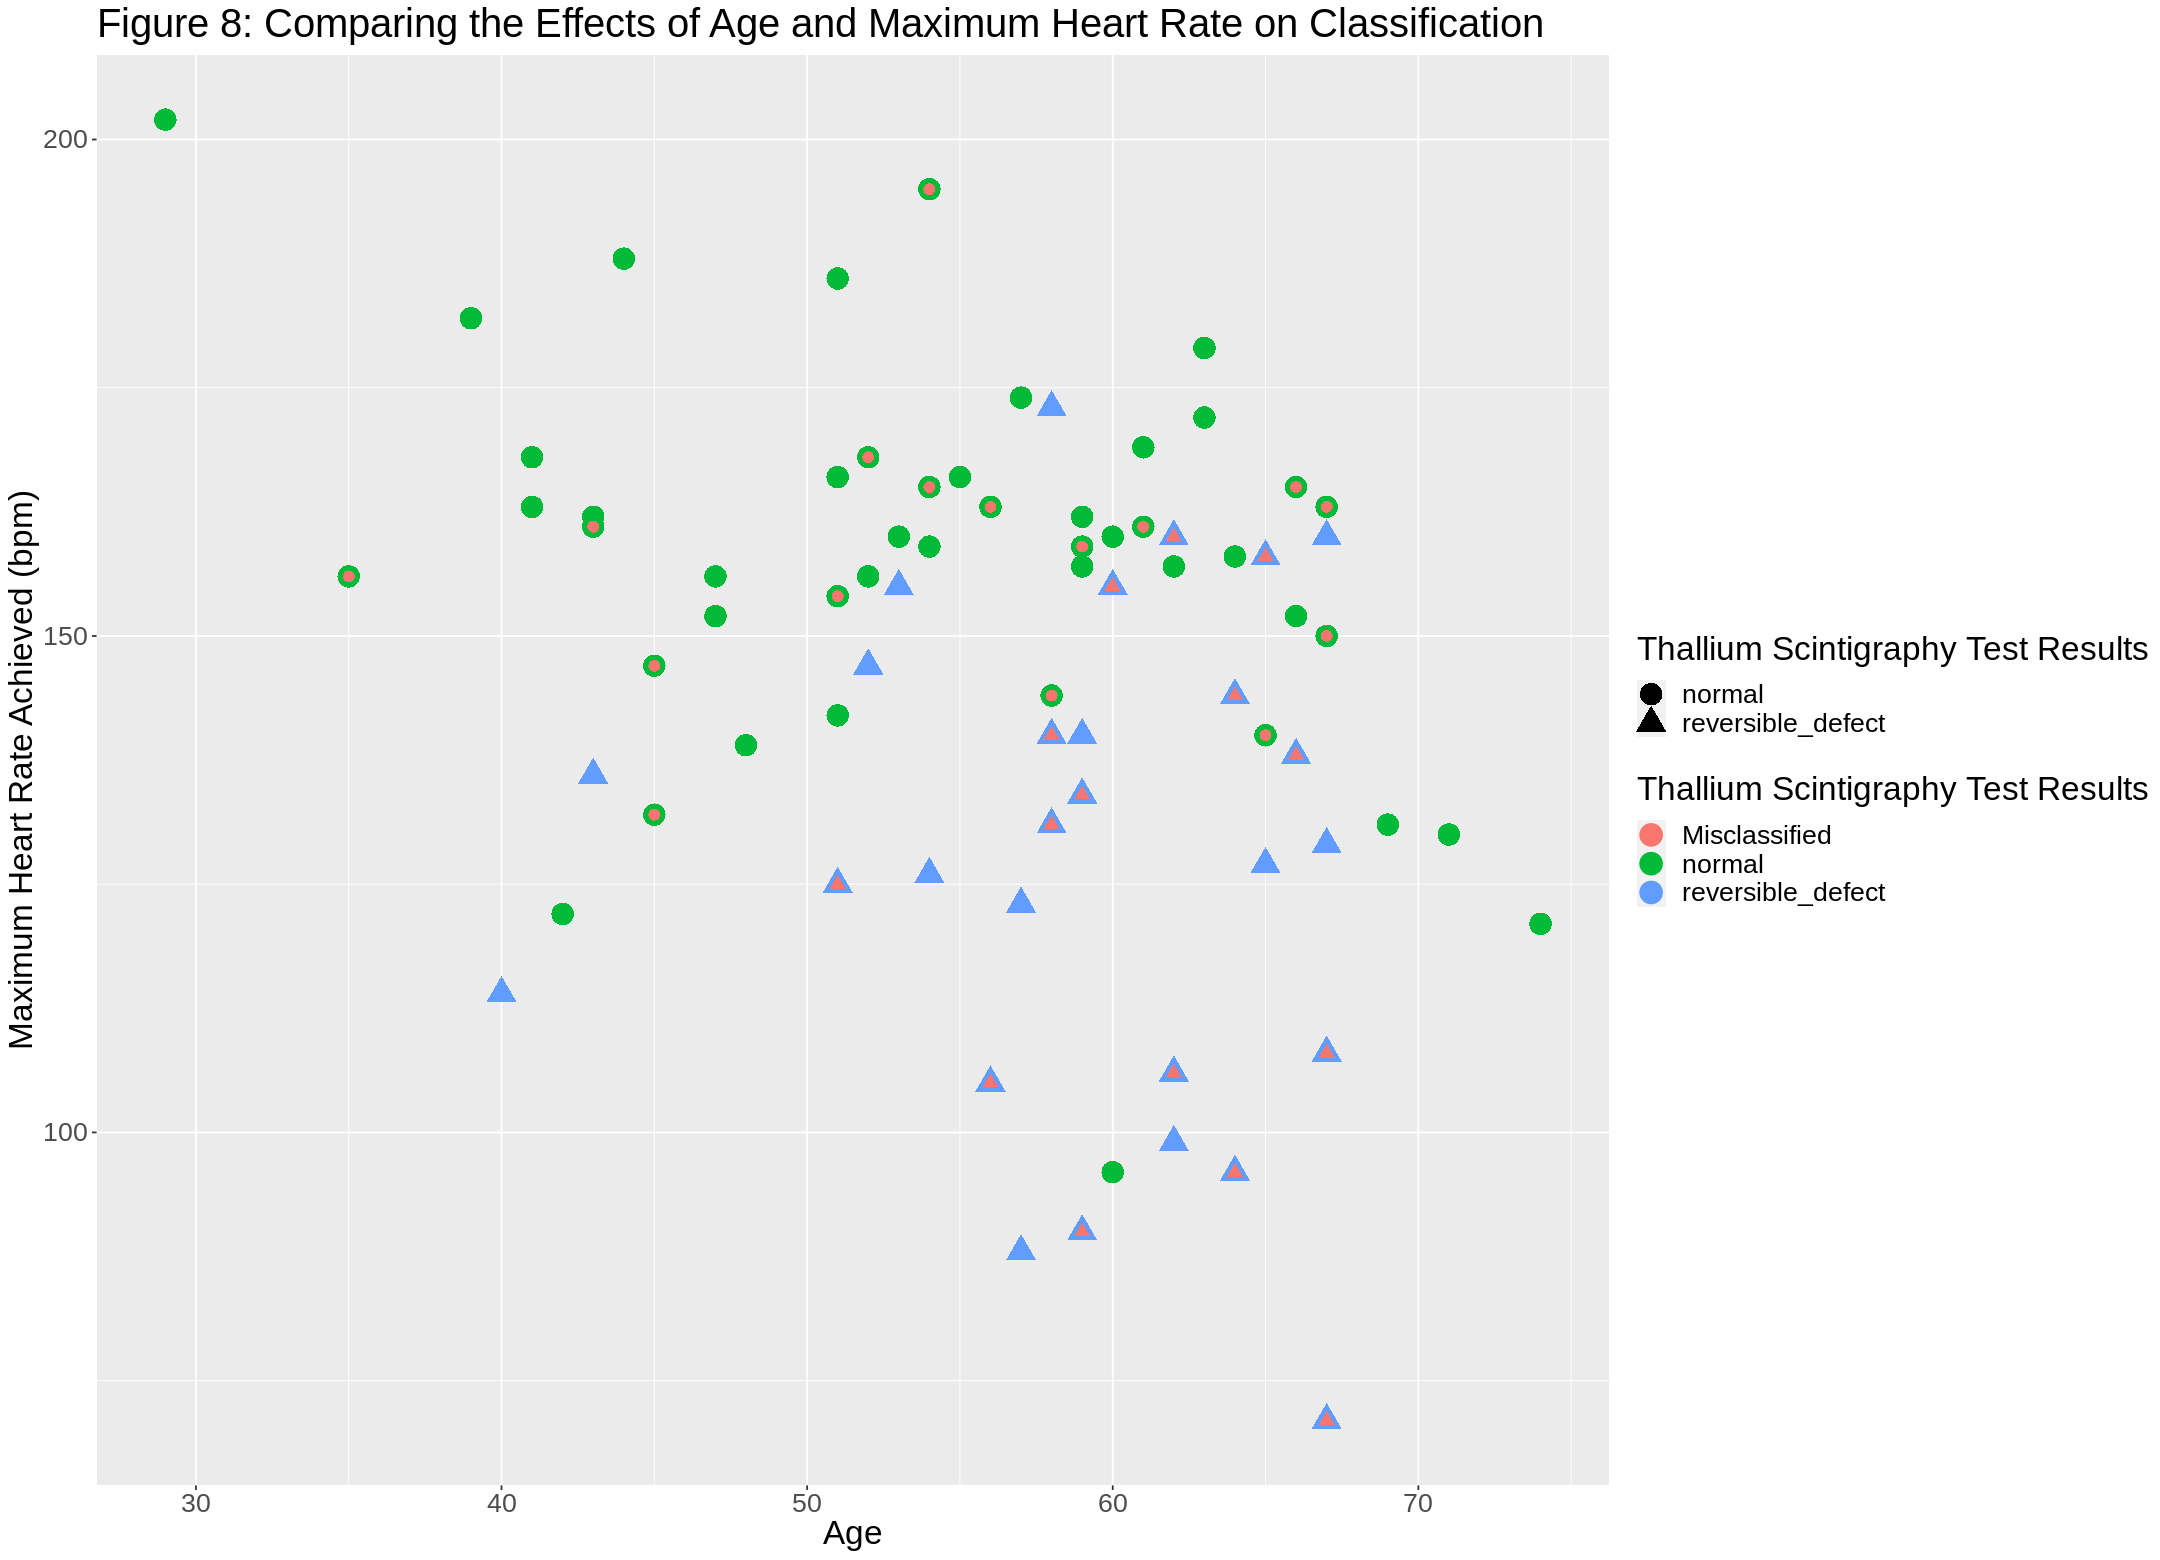

In [21]:
misclass_plot_2_pred <- ggplot(cleveland_predictions, aes(x = age, y = thalach, color = .pred_class, shape = .pred_class)) +
                geom_point(size = 6) +
                geom_point(data = cleveland_misclass, aes(x = age, y = thalach, color = 'Misclassified'), size = 3) +
                labs(x = "Age", y = "Maximum Heart Rate Achieved (bpm)", 
                     title = "Figure 8: Comparing the Effects of Age and Maximum Heart Rate on Classification", 
                     color = "Thallium Scintigraphy Test Results", shape = "Thallium Scintigraphy Test Results") +
                theme(text = element_text(size = 20))
misclass_plot_2_pred


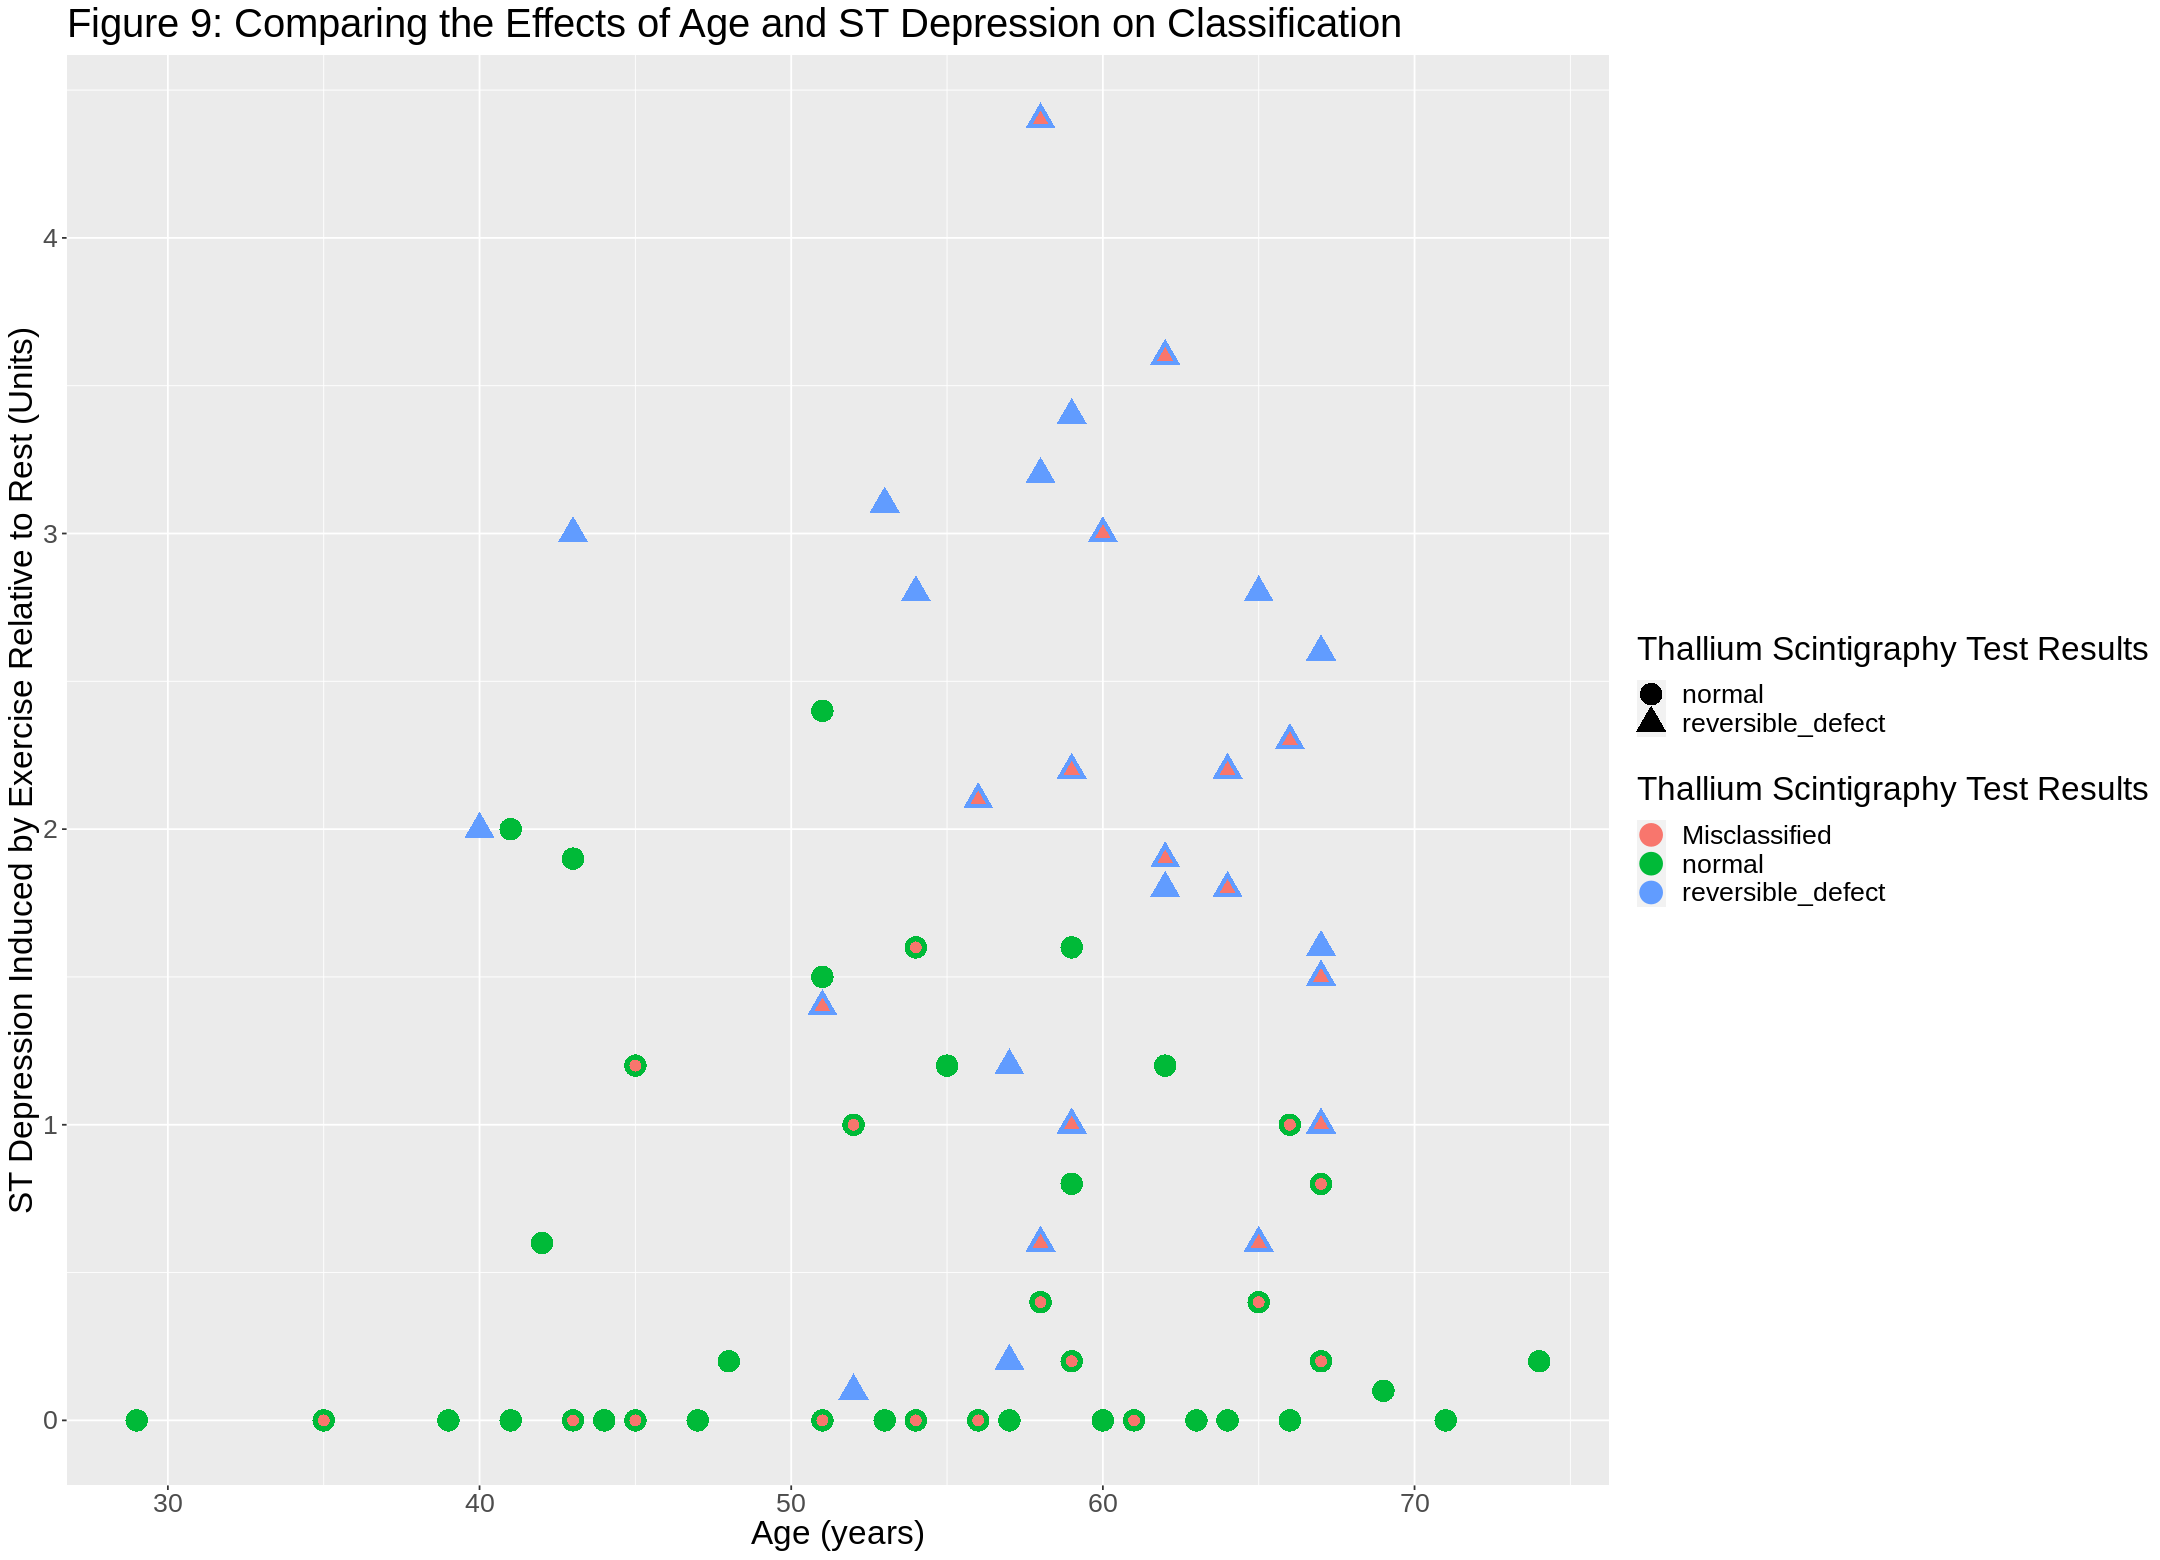

In [22]:
misclass_plot_3_pred <- ggplot(cleveland_predictions, aes(x = age, y = oldpeak, color = .pred_class, shape = .pred_class)) +
                geom_point(size = 6) +
                geom_point(data = cleveland_misclass, aes(x = age, y = oldpeak, color = 'Misclassified'), size = 3) +
                labs(x = "Age (years)", y = "ST Depression Induced by Exercise Relative to Rest (Units)", 
                     title = "Figure 9: Comparing the Effects of Age and ST Depression on Classification", 
                     color = "Thallium Scintigraphy Test Results", shape = "Thallium Scintigraphy Test Results") +
                theme(text = element_text(size = 20))
misclass_plot_3_pred

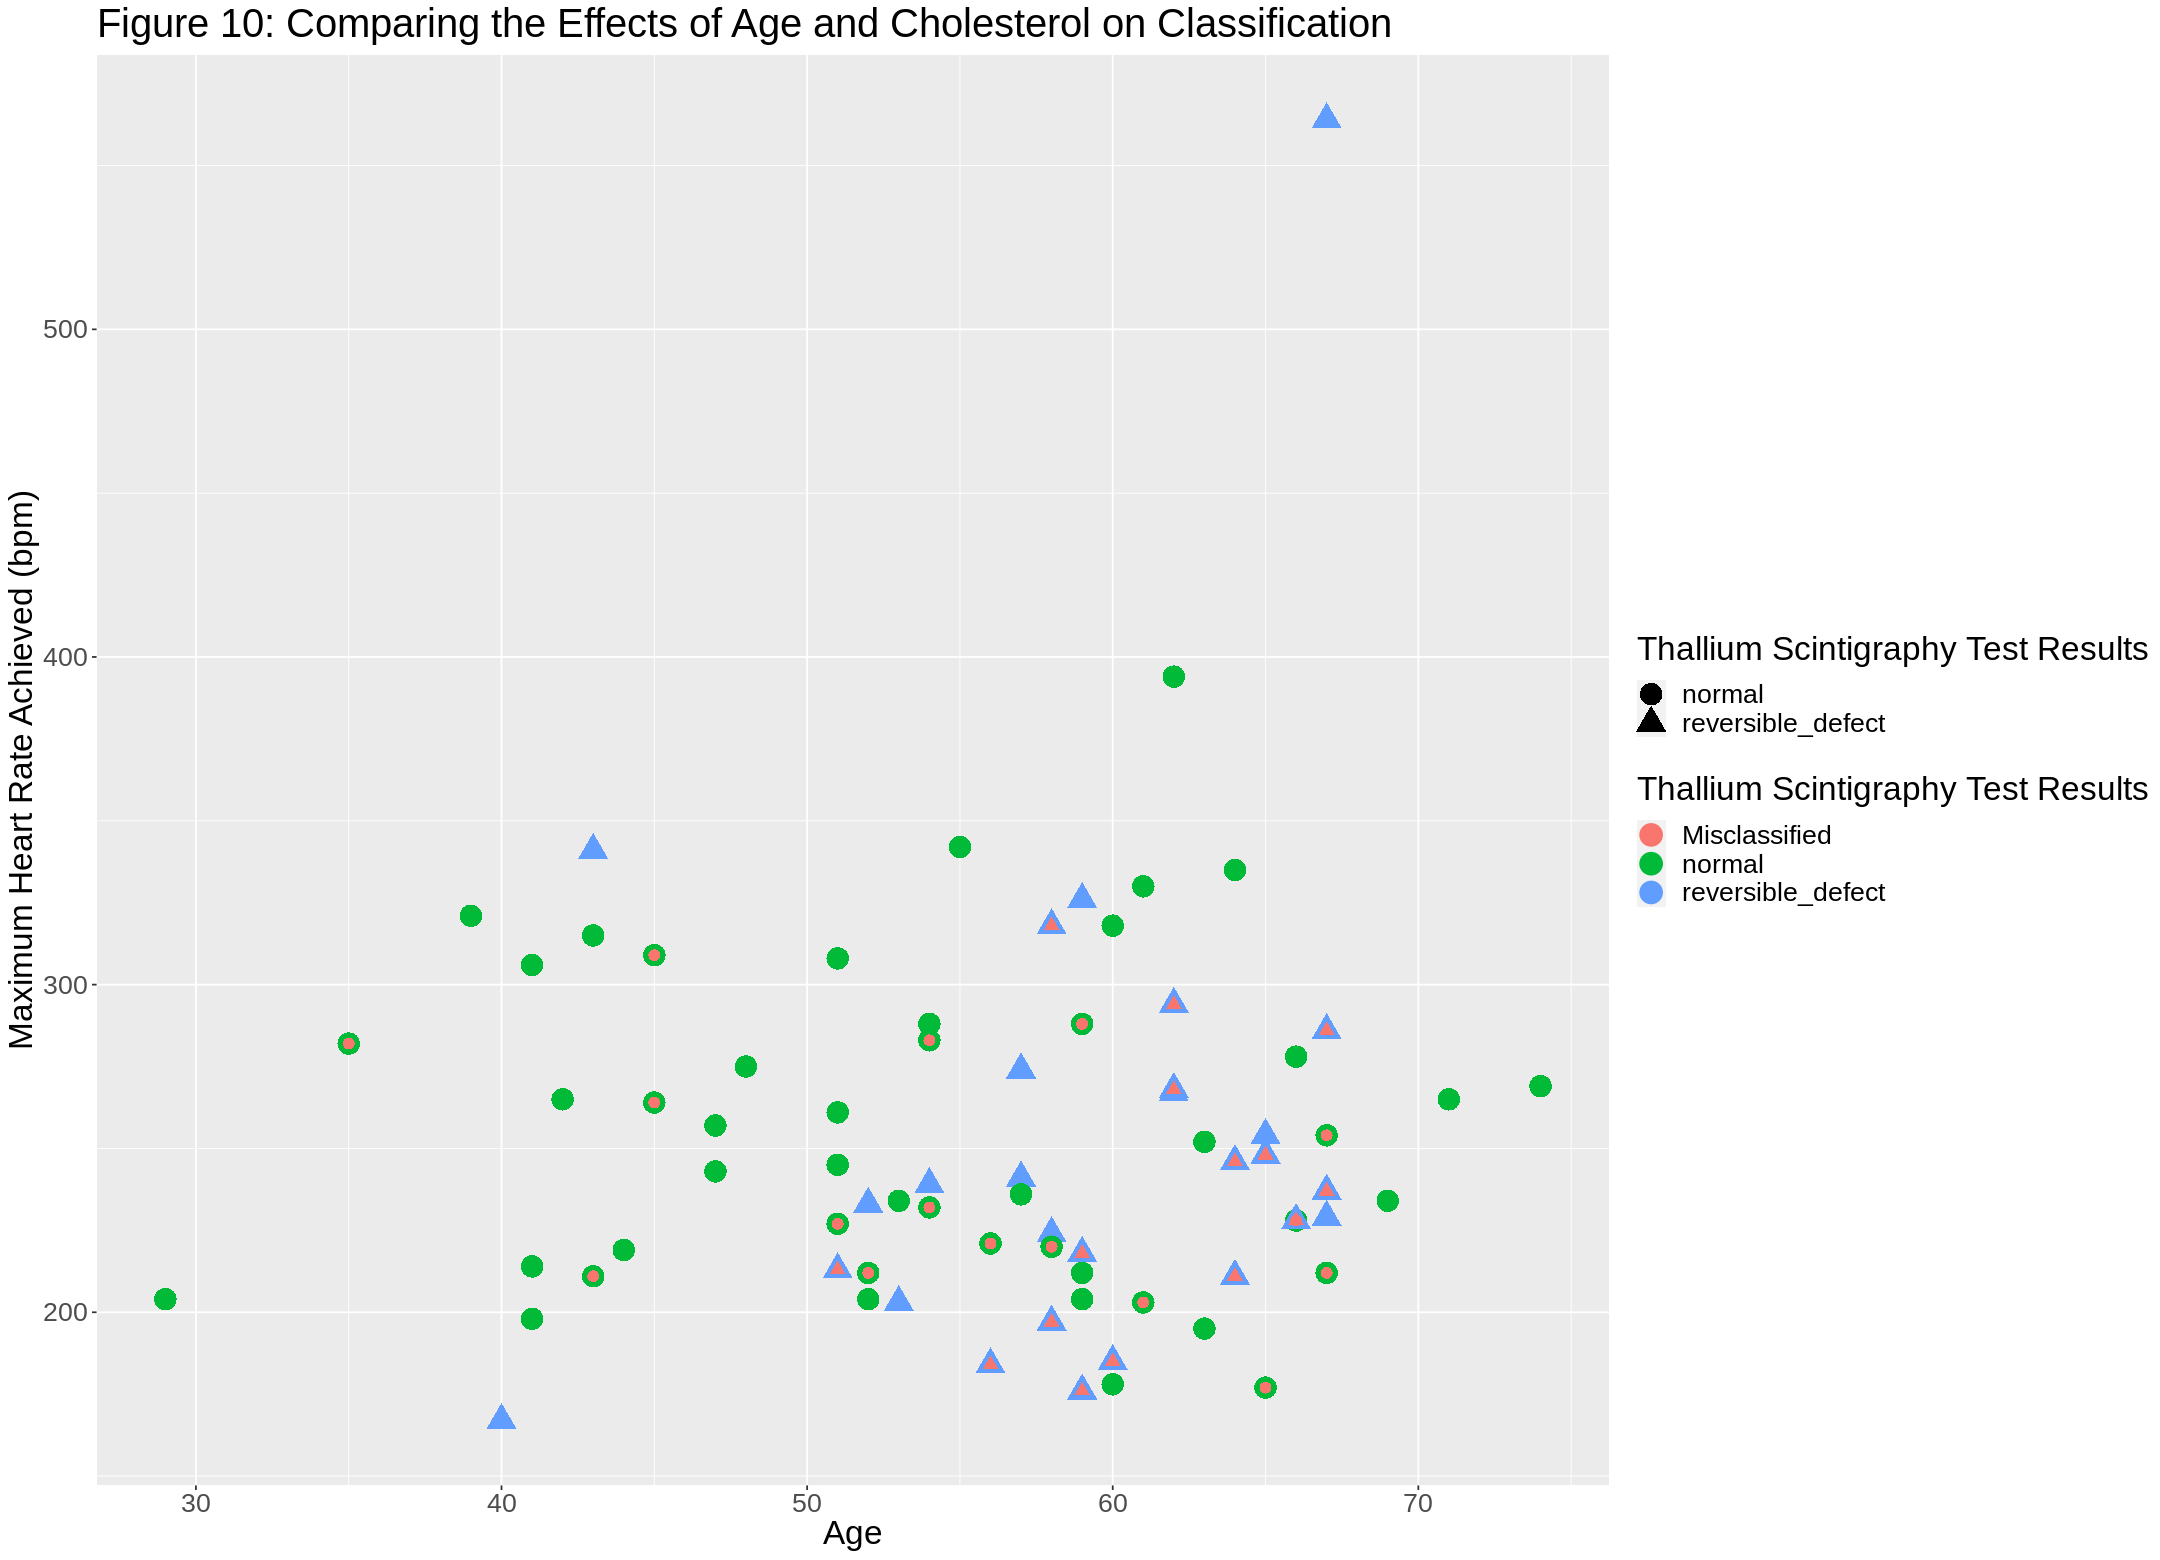

In [23]:
misclass_plot_2_pred <- ggplot(cleveland_predictions, aes(x = age, y = chol, color = .pred_class, shape = .pred_class)) +
                geom_point(size = 6) +
                geom_point(data = cleveland_misclass, aes(x = age, y = chol, color = 'Misclassified'), size = 3) +
                labs(x = "Age", y = "Maximum Heart Rate Achieved (bpm)", 
                     title = "Figure 10: Comparing the Effects of Age and Cholesterol on Classification", 
                     color = "Thallium Scintigraphy Test Results", shape = "Thallium Scintigraphy Test Results") +
                theme(text = element_text(size = 20))
misclass_plot_2_pred